# EXPLORED EDA - TIME SERIES

In [52]:
# -------------------------------
# IMPORTS
# -------------------------------

# Main libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Decompose time-series in 3 components: trend, seasonal and resid
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

# To evaluate the seasonality of the time series we can apply the so-called Dickey-Fuller test
# It is a hypothesis test in which the null hypothesis is that the series is stationary
# The alternative, that it is non-stationary:
from statsmodels.tsa.stattools import adfuller
# Autocorrelation is the correlation of a time series with a lagged copy of itself.
# This graph helps us see if the values ​​in the time series are correlated with previous values.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#ARIMA model
from statsmodels.tsa.arima.model import ARIMA
# Automate the selection of the best parameters for an ARIMA model, saving time compared to manual tuning.
from pmdarima import auto_arima

In [18]:
def log(message: str, level: int = 1, type: str = "INFO", custom_icon: str = None, bold: bool = False):
    # Default icons according to message type
    icons = {
        "INFO": "ℹ️",
        "FOUND": "🔍",
        "SUCCESS": "✅",
        "ERROR": "❌",
        "WARNING": "⚠️",
    }
    # Use custom icon if provided
    if custom_icon:
        icon = custom_icon
    else:
        icon = icons.get(type.upper(), "ℹ️")
    # Bold wrapper (ANSI)
    if bold:
        message = f"\033[1m{message}\033[0m"
    # First level → bullet
    if level == 1:
        prefix = "•"
    # Second level → indent + hyphen
    elif level == 2:
        prefix = "   -"
    # Level 3 → deeper indent + middle dot
    elif level == 3:
        prefix = "      ·"
    # Fallback
    else:
        prefix = "-"
    # Final print
    print(f"{prefix} {icon} {message}")

# Determines granularity given seconds
def determine_granularity(seconds: float):
    if seconds < 1:
        granularity = "sub-second"
    elif seconds >= 1 and seconds < 60:
        granularity = "second"
    elif seconds >= 60 and seconds < 3600:
        granularity = "minute"
    elif seconds >= 3600 and seconds < 86400:
        granularity = "hour"
    elif seconds == 86400:
        granularity = "day"
    elif seconds > 86400 and seconds <= 86400 * 7:
        granularity = "multi-day"
    elif seconds == 86400 * 7:
        granularity = "week"
    elif seconds > 86400 * 7 and seconds < 86400 * 28:
        granularity = "weekly-to-monthly"
    elif seconds >= 86400 * 28 and seconds <= 86400 * 31:
        granularity = "month"
    elif seconds > 86400 * 31 and seconds <= 86400 * 92:
        granularity = "quarter"
    else:
        granularity = "year-or-more"
    return granularity

# Detects whether the seasonal decomposition model should be
# 'additive' (constant amplitude) or 
# 'multiplicative'(amplitude grows with the trend)
def infer_seasonal_component_type(series: pd.Series, threshold: float) -> str:
    # Compute amplitude and mean
    amplitude = series.max() - series.min()
    mean_val = series.mean()
    # Edge case: zero-mean → multiplicative impossible
    if mean_val == 0:
        return "additive"
    # Threshold for deciding multiplicative
    if amplitude / abs(mean_val) > threshold:
        return "multiplicative"
    else:
        return "additive"

#  Detects seasonality period automatically using the first significant ACF peak
def infer_period_from_acf(series: pd.Series, max_lag_ratio: float = 0.1):
    n = len(series)
    max_lag = max(5, int(n * max_lag_ratio))
    # Compute autocorrelation using FFT
    autocorr = acf(series, nlags=max_lag, fft=True, missing="drop")
    # Ignore lag 0
    autocorr[0] = 0
    # Find the highest correlation peak
    peak_lag = np.argmax(autocorr)
    # If the peak is too low → no seasonality
    if autocorr[peak_lag] < 0.3:
        return None
    return peak_lag

#  Detects seasonality period automatically using Granularity (fallback when ACF fails or data is too noisy)
def infer_period_from_granularity(granularity: str):
    if granularity == "sub-second":
        return None
    if granularity == "second":
        return 60
    if granularity == "minute":
        return 60
    if granularity == "hour":
        return 24
    if granularity == "day":
        return 7  # Most common weekly cycle IF the series shows any seasonality
    if granularity == "multi-day":
        return 7
    if granularity == "week":
        return 52
    if granularity == "weekly-to-monthly":
        return 12
    if granularity == "month":
        return 12
    if granularity == "quarter":
        return 4
    return None # Yearly or undefined → no decomposition

# 6) Evaluates how strong the seasonality is using:
# 1) Variance ratio: Var(seasonal) / Var(original)
# 2) ACF at the seasonal period
def assess_seasonality_strength(original: pd.Series, seasonal: pd.Series, period: int, acf_threshold: float, var_ratio: float):
    # Align indices and remove NaN values from the seasonal component
    valid_mask = seasonal.notna()
    original_valid = original[valid_mask]
    seasonal_valid = seasonal[valid_mask]
    # If there are not enough valid points → cannot assess
    if len(original_valid) < max(10, period * 2):
        metrics = {
            "seasonal_var_ratio": np.nan,
            "acf_at_period": np.nan
        }
        return False, metrics
    # 1) Variance ratio
    total_var = np.var(original_valid)
    seasonal_var = np.var(seasonal_valid)
    if total_var == 0:
        seasonal_var_ratio = 0.0
    else:
        seasonal_var_ratio = seasonal_var / total_var
    # 2) ACF at seasonal period
    acf_values = acf(
        original_valid,
        nlags = period,
        fft = True,
        missing = "drop"
    )
    acf_at_period = acf_values[period]
    # 3) Decision rule
    strong_seasonality = ((seasonal_var_ratio >= var_ratio) and (acf_at_period >= acf_threshold))
    # 4) Metrics
    metrics = {
        "seasonal_var_ratio": seasonal_var_ratio,
        "acf_at_period": acf_at_period
    }
    return strong_seasonality, metrics

# Performs Dickey-Fuller test to determine if a series is stacionary or not
def test_stationarity(series):
    dftest = adfuller(series, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

# Recursively differences the time-series until Dickey-Fuller test accepts stationarity (p < alpha)
def make_stationary_recursive(series, alpha: float = 0.05, max_diff: int = 5):
    current_series = series.copy()
    diff_count = 0
    while diff_count <= max_diff:
        test_results = test_stationarity(current_series)
        if test_results["p-value"] < alpha:
            return current_series, diff_count, test_results
        current_series = current_series.diff().dropna()
        diff_count += 1
    # If exceeded max_diff → return last attempt
    return current_series, diff_count, test_results

## STEP 0 - LOAD RAW DATAFRAME

In [3]:
# Raw dataset formatting
data_separator = ","
input_path = "../data/raw/internal-link.csv"
# Thresholds for dataset type proposal (NLP)
min_text_avg_length = 25      # Recommended: 20–30 chars → typical minimum for real text
min_text_avg_words  = 3       # Recommended: >3 words → avoids titles/labels
# Thresholds for dataset type proposal (Time-Series)
min_rows_in_dataset = 75      # Recommended: > 75
max_numeric_var = 5           # More than 5 is odd for a time-series
freq_ratio_threshold = 0.7    # Recommended: > 0.7 (values from 0 to 1)
# Plotting
figHeight_unit = 8
figWidth_unit = 12  


In [4]:
print("STEP 0) LOAD RAW DATAFRAME")

# Load raw DataFrame
df_raw = pd.read_csv(input_path, sep=data_separator)
log("DataFrame loaded successfully!", type="SUCCESS")

# ---------------------------------------------------------
# NLP CHECKING (probabilistic)
# ---------------------------------------------------------
log("NLP cheking:", custom_icon="📝")
nlp_score = 0            # Final probability score (0–100)
nlp_diag = []            # Diagnostic report

# Evidence 1: dataset has at least one text-like column
object_cols = []
for col in df_raw.columns:
    if df_raw[col].dtype in ["object", "category"]:
        object_cols.append(col)
if len(object_cols) >= 1:
    nlp_score += 25
    log(f"Object-type columns found: {object_cols} -> + {nlp_score}%", level=2, type="SUCCESS")
else:
    log("No object-type columns found", level=2, type="ERROR")

# Evidence 2: long text columns exist
text_cols = []
for col in object_cols:
    avg_len = df_raw[col].dropna().str.len().mean()
    if avg_len is not None and avg_len > min_text_avg_length:
        text_cols.append(col)
if len(text_cols) >= 1:
    nlp_score += 25
    log(f"Long text-like columns found: {text_cols} -> + {nlp_score}%", level=2, type="SUCCESS")
else:
    log("No long text-like columns found", level=2, type="ERROR")

# Evidence 3: rich text structure (words per entry)
rich_text_cols = []
for col in text_cols:
    avg_words = df_raw[col].dropna().str.split().str.len().mean()
    if avg_words is not None and avg_words > min_text_avg_words:
        rich_text_cols.append(col)
if len(rich_text_cols) > 0:
    nlp_score += 25
    log(f"At least one column shows word-rich entries -> + {nlp_score}%", level=2, type="SUCCESS")
else:
    log("No column shows word-rich entries", level=2, type="ERROR")

# Evidence 4: number of text columns realistic for NLP
if len(text_cols) == 1:
    nlp_score += 15
    log(f"There is only 1 long text-like column, it is typical for NLP -> + {nlp_score}%", level=2, type="SUCCESS")
elif len(text_cols) > 1:
    nlp_score += 5
    log(f"There are more than 1 long text-like column, it could be possible for NLP -> + {nlp_score}%", level=2, type="SUCCESS")
else:
    log("No long text-like columns found", level=2, type="ERROR")

# Evidence 5: proportion of non-empty text entries
if len(text_cols) >= 1:
    non_empty_ratio = df_raw[text_cols[0]].dropna().str.len().gt(10).mean()
    if non_empty_ratio >= 0.6:
        nlp_score += 10
        log(f"Majority of rows contain meaningful text -> + {nlp_score}%", level=2, type="SUCCESS")
    else:
        log("Too many empty/short text entries", level=2, type="ERROR")

# Cap score at 100
nlp_score = min(nlp_score, 100)
log(f"Probability score to be a NLP Dataset: {nlp_score}%", level=2, type="INFO")

# ---------------------------------------------------------
# TIME-SERIES CHECKING (probabilistic)
# ---------------------------------------------------------
log("TIME-SERIES checking:", custom_icon="⏱️")
ts_score = 0                  # Final probability score (0–100)
ts_cols = []                  # List of detected datetime columns
ts_main_col = None            # Main datetime column chosen
ts_diag = []                  # Diagnostic list

# ---------------------------------------------------------
# Evidence 1) Detect datetime columns (robust)
# ---------------------------------------------------------
# Try to parse every column → if successful → datetime candidate
for col in df_raw.columns:
    try:
        pd.to_datetime(df_raw[col], errors="raise")
        ts_cols.append(col)
    except:
        pass

# Case 1 → no datetime columns
if len(ts_cols) == 0:
    log("No datetime columns detected", level=2, type="ERROR")
# Case 2 → exactly one column
elif len(ts_cols) == 1:
    ts_score += 40
    ts_main_col = ts_cols[0]
    log(f"Unique datetime column detected: {ts_main_col} -> + {ts_score}%", level=2, type="SUCCESS")
# Case 3 → multiple datetime columns
elif len(ts_cols) > 1:
    ts_score += 25
    ts_main_col = ts_cols[0]
    log(f"Several datetime columns were detected: {ts_cols} -> + {ts_score}%", level=2, type="SUCCESS")
    # Check if all datetime columns share similar structure
    for col in ts_cols:
        try:
            dt_tmp = pd.to_datetime(df_raw[col], errors="coerce")
            missing_rate = dt_tmp.isna().mean()
            log(f"Column '{col}' parsed with missing rate: {missing_rate:.3f}", level=3, type="INFO")
        except:
            log(f"Column '{col}' failed advanced parsing", level=3, type="ERROR")

if ts_main_col is not None: # Evaluate time-series structure (only if datetime column exists)

    # Convert chosen datetime column
    serie_date_time_raw = pd.to_datetime(df_raw[ts_main_col], errors="coerce")

    # ---------------------------------------------------------
    # Evidence 2) Chronologically sorted
    # ---------------------------------------------------------
    if serie_date_time_raw.is_monotonic_increasing:
        ts_score += 20
        log(f"Datetime column '{ts_main_col}' is sorted -> + {ts_score}%", level=2, type="SUCCESS")
    else:
        log(f"Datetime column '{ts_main_col}' is NOT sorted", level=2, type="ERROR")

    # ---------------------------------------------------------
    # Evidence 3) Detecting time-series frequency
    # ---------------------------------------------------------
    serie_date_time_diff_raw = serie_date_time_raw.diff().dropna()

    if len(serie_date_time_diff_raw) > 0:
        # Compute most common interval
        most_common_delta = serie_date_time_diff_raw.mode()[0]
        freq_ratio = (serie_date_time_diff_raw == most_common_delta).mean()
        if freq_ratio >= freq_ratio_threshold:
            ts_score += 20
            log(f"Regular frequency detected -> + {ts_score}%", level=2, type="SUCCESS")
            log(f"Frequency consistency ratio: {freq_ratio:.3f}", level=3, type="INFO")
        else:
            log("No regular frequency detected", level=2, type="ERROR")
    else:
        log("Not enough data to detect time-series frequency", level=2, type="ERROR")

    # ---------------------------------------------------------
    # Evidence 4) Numeric columns over time
    # ---------------------------------------------------------
    numeric_cols = df_raw.select_dtypes(include=["number"]).columns
    if 1 <= len(numeric_cols) <= max_numeric_var:
        ts_score += 10
        log(f"Numeric variables suitable for TS -> + {ts_score}%", level=2, type="SUCCESS")
    elif len(numeric_cols) < 1:
        log("There is not at least one numeric variable for time-series", level=2, type="ERROR")
    else:
        log("Too many numeric varaibles for time-series", level=2, type="ERROR")

    # ---------------------------------------------------------
    # Evidence 5) Dataset length
    # ---------------------------------------------------------
    if len(df_raw) >= min_rows_in_dataset:
        ts_score += 10
        log(f"Enough rows for time-series -> + {ts_score}%", level=2, type="SUCCESS")
    else:
        log("Dataset too short for time-series", level=2, type="ERROR")

# Cap score at 100
ts_score = min(ts_score, 100)

log(f"Probability score to be a TIME-SERIES Dataset: {ts_score}%", level=2, type="INFO")

# ---------------------------------------------------------
# Dataset type proposal
# ---------------------------------------------------------
if ts_score >= nlp_score and ts_score >= 75:
    dataset_type_auto = "TIME-SERIES"
elif nlp_score >= ts_score and nlp_score >= 75:
    dataset_type_auto = "NLP"
else:
    dataset_type_auto = "TABULAR"
print("----------------------------------------")
log(f"Proposed dataset type: {dataset_type_auto}", type="INFO", bold=True)
print("----------------------------------------")

STEP 0) LOAD RAW DATAFRAME
• ✅ DataFrame loaded successfully!
• 📝 NLP cheking:
   - ✅ Object-type columns found: ['date'] -> + 25%
   - ✅ Long text-like columns found: ['date'] -> + 50%
   - ❌ No column shows word-rich entries
   - ✅ There is only 1 long text-like column, it is typical for NLP -> + 65%
   - ✅ Majority of rows contain meaningful text -> + 75%
   - ℹ️ Probability score to be a NLP Dataset: 75%
• ⏱️ TIME-SERIES checking:
   - ✅ Several datetime columns were detected: ['date', 'sales'] -> + 25%
      · ℹ️ Column 'date' parsed with missing rate: 0.000
      · ℹ️ Column 'sales' parsed with missing rate: 0.000
   - ✅ Datetime column 'date' is sorted -> + 45%
   - ✅ Regular frequency detected -> + 65%
      · ℹ️ Frequency consistency ratio: 1.000
   - ✅ Numeric variables suitable for TS -> + 75%
   - ✅ Enough rows for time-series -> + 85%
   - ℹ️ Probability score to be a TIME-SERIES Dataset: 85%
----------------------------------------
• ℹ️ Proposed dataset type: TIME-SERIES


## STEP 1 - EXPLORE DATAFRAME

In [5]:
dataset_type = "TIME-SERIES" # Confirm dataset type (TIME-SERIES, NLP or TABULAR)
ts_main_col_index = 0 # Needed if TIME-SERIES is selected

In [6]:
# -------------------------------
# STEP 1) EXPLORE DATAFRAME
# -------------------------------
print("STEP 1) EXPLORE DATAFRAME")

# Copy original DataFrame
df_S1 = df_raw.copy()

# -------------------------------
# NLP DATASET
# -------------------------------
if dataset_type == "NLP":
    log("Dataset detected as NLP (long-text dataset)", custom_icon="📝")

    # Print info
    log(f"Shape of the DataFrame: {df_S1.shape}", type="INFO")
    log("Content of the DataFrame:", type="INFO")
    display(df_S1.head(5))
    log("Sample of raw text entries:", type="INFO")
    display(df_S1[text_cols].head(5))

    # Print text length stats
    df_S1_lengths = df_S1[text_cols[0]].astype(str).str.len()
    log("Text length statistics:", type="INFO")
    log(f"Average lengths: {df_S1_lengths.mean():.1f} chars", level=2, custom_icon="📊")
    log(f"Median lengths: {df_S1_lengths.median():.1f} chars", level=2, custom_icon="📊")
    log(f"Max lengths: {df_S1_lengths.max():.1f} chars", level=2, custom_icon="📊")

    # Compute word statistics
    df_S1_words = df_S1[text_cols[0]].astype(str).str.split().str.len()
    log("Word count statistics:", type="INFO")
    log(f"Average words: {df_S1_words.mean():.1f} chars", level=2, custom_icon="📊")
    log(f"Median words: {df_S1_words.median():.1f} chars", level=2, custom_icon="📊")
    log(f"Max words: {df_S1_words.max():.1f} chars", level=2, custom_icon="📊")

# -------------------------------
# TIME-SERIES DATASET
# -------------------------------
elif dataset_type == "TIME-SERIES":
    log("Dataset detected as TIME-SERIES", custom_icon="⏱️")

    # Print info
    log(f"Shape of the DataFrame: {df_S1.shape}", type="INFO")
    log("Content of the DataFrame:", type="INFO")
    display(df_S1.head(5))

    # Try to parse every column
    df_S1_ts_cols = []
    for col in df_S1.columns:
        try:
            pd.to_datetime(df_S1[col], errors="raise")
            df_S1_ts_cols.append(col)
        except:
            pass

    # Time column
    df_S1_ts_main_col = df_S1_ts_cols[ts_main_col_index]
    serie_date_time_S1 = pd.to_datetime(df_S1[df_S1_ts_main_col], errors="coerce")
    log("Time index information:", type="INFO")
    log(f"Detected time column: '{df_S1_ts_main_col}'", level=2, custom_icon="📅")
    log(f"Start date: {serie_date_time_S1.min()}", level=2, custom_icon="📅")
    log(f"End date: {serie_date_time_S1.max()}", level=2, custom_icon="📅")
    log(f"Total duration: {serie_date_time_S1.max() - serie_date_time_S1.min()}", level=2, custom_icon="📅")

    # Estimate frequency and granularity
    serie_date_time_diff_S1 = serie_date_time_S1.diff().dropna()
    if len(serie_date_time_diff_S1) > 0:
        df_S1_most_common_delta = serie_date_time_diff_S1.mode()[0] # Most common interval
        df_S1_smallest_delta = serie_date_time_diff_S1.min() # Minimal interval
        df_S1_freq_ratio = (serie_date_time_diff_S1 == df_S1_most_common_delta).mean()
        # Determine granularity
        df_S1_seconds = df_S1_most_common_delta.total_seconds()
        granularity = determine_granularity(df_S1_seconds)
        log(f"Most common interval: {df_S1_most_common_delta} (granularity: {granularity})", level=2, custom_icon="📅")
        log(f"Smallest interval: {df_S1_smallest_delta}", level=2, custom_icon="📅")
        log(f"Frequency consistency ratio: {df_S1_freq_ratio:.3f}", level=2, custom_icon="📅")
    else:
        log("Not enough data points to estimate frequency", type="WARNING")

    # Missing or irregular timestamps
    missing_ratio = 1 - (serie_date_time_diff_S1 == most_common_delta).mean() if len(serie_date_time_diff_S1) > 0 else None
    if missing_ratio is not None and missing_ratio > 0.10:
        log("Irregular timestamps detected (missing or uneven intervals)", type="WARNING")
        log(f"Irregularity ratio: {missing_ratio:.2f}", level=2, custom_icon="⚠️")

    # Numeric metrics
    numeric_cols = df_S1.select_dtypes(include=["number"]).columns
    log("Numeric metrics detected:", type="INFO")
    for col in numeric_cols:
        log(f"{col}", level=2, custom_icon="📈")

    # Statistics for each metric
    log("Basic statistics per numeric variable:", type="INFO")
    display(df_S1[numeric_cols].describe().T)

# -------------------------------
# TABULAR DATASET
# -------------------------------
elif dataset_type == "TABULAR":
    log("Dataset detected as TABULAR", custom_icon="🧮")

    # Print info
    log(f"Shape of the DataFrame: {df_S1.shape}", type="INFO")
    log("Content of the DataFrame:", type="INFO")
    display(df_S1.head(5))
    log("Info of the DataFrame (dataType and non-null values):", type="INFO")
    df_S1.info(verbose=True, show_counts=True)

    # Ordered info (fewest non-null first)
    ordered_info = pd.DataFrame({
        "Column": df_S1.columns,
        "Non-Null Count": df_S1.notnull().sum(),
        "Null Count": df_S1.isnull().sum(),
        "Dtype": df_S1.dtypes.astype(str)
    }).sort_values(by="Non-Null Count", ascending=True)
    log("Ordered info by number of non-null values:", type="INFO")
    display(ordered_info)

    # Count unique attributes (unsorted)
    df_S1_summary = pd.DataFrame({
        "Column": df_S1.columns,
        "Unique_Count": df_S1.nunique().values
    })
    log("DataFrame unique attributes (unsorted):", type="INFO")
    display(df_S1_summary)

    # Ordered summary (fewest unique first)
    df_S1_summary_ordered = df_S1_summary.sort_values(by="Unique_Count", ascending=True)
    log("Ordered unique attributes (fewest unique first):", type="INFO")
    display(df_S1_summary_ordered)

    # Automatic Warning for high-uniqueness columns
    unique_counts = df_S1.nunique()
    high_unique_cols = unique_counts[unique_counts == len(df_S1)].index.tolist()
    if len(high_unique_cols) > 0:
        log("Consider dropping the following columns for having UNIQUE values for EVERY row:", type="WARNING")
        for col in high_unique_cols:
            log(f"{col}", level=2, custom_icon="🗑️")

STEP 1) EXPLORE DATAFRAME
• ⏱️ Dataset detected as TIME-SERIES
• ℹ️ Shape of the DataFrame: (366, 2)
• ℹ️ Content of the DataFrame:


,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


• ℹ️ Time index information:
   - 📅 Detected time column: 'date'
   - 📅 Start date: 2022-09-03 17:10:08.079328
   - 📅 End date: 2023-09-03 17:10:08.079328
   - 📅 Total duration: 365 days 00:00:00
   - 📅 Most common interval: 1 days 00:00:00 (granularity: day)
   - 📅 Smallest interval: 1 days 00:00:00
   - 📅 Frequency consistency ratio: 1.000
• ℹ️ Numeric metrics detected:
   - 📈 sales
• ℹ️ Basic statistics per numeric variable:


,count,mean,std,min,25%,50%,75%,max
sales,366.0,524.963968,275.089698,53.803211,290.186822,520.699468,763.289263,1000.482785


CONCLUSIONS:
- GRANULARITY: 1 day
- TOTAL DURATION: 365 days
- SMALLEST INTERVAL: 1day

STEP 2) BUILD TIME SERIES
• 🔍 Detected temporal column: 'date'
• ℹ️ Indexed DataFrame by 'date'
• ℹ️ Preview of time-indexed DataFrame:


,sales
date,
2022-09-03 17:10:08.079328,55.292157
2022-09-04 17:10:08.079328,53.803211
2022-09-05 17:10:08.079328,58.141693
2022-09-06 17:10:08.079328,64.530899
2022-09-07 17:10:08.079328,66.013633


• ✅ Extracted target time-series 'sales'


date
2022-09-03 17:10:08.079328    55.292157
2022-09-04 17:10:08.079328    53.803211
2022-09-05 17:10:08.079328    58.141693
2022-09-06 17:10:08.079328    64.530899
2022-09-07 17:10:08.079328    66.013633
Name: sales, dtype: float64

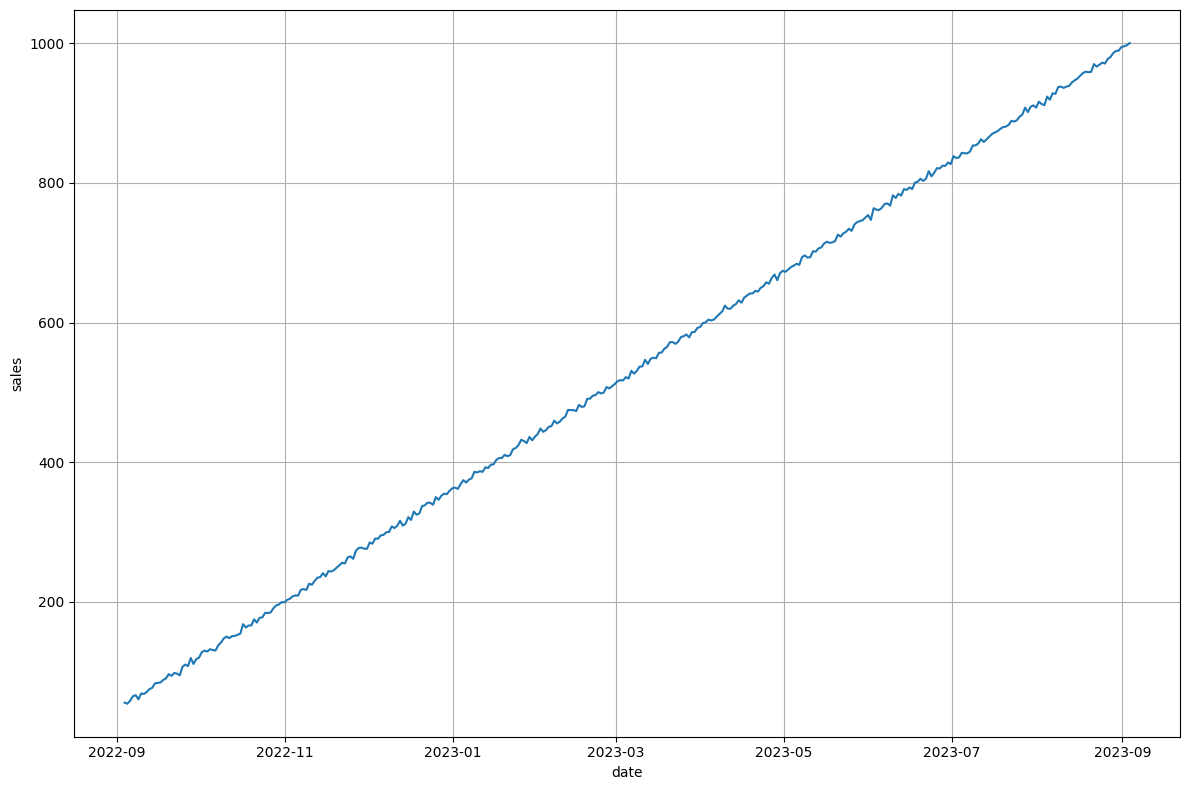

In [54]:
# -------------------------------
# STEP 2) BUILD TIME SERIES
# -------------------------------
print("STEP 2) BUILD TIME SERIES")

# Copy previous DataFrame
df_S2 = df_S1.copy()
df_S2_ts_main_col = df_S1_ts_main_col

if dataset_type == "TIME-SERIES":
    # Identify the temporal column
    if len(df_S2_ts_main_col) > 0:
        log(f"Detected temporal column: '{df_S2_ts_main_col}'", type="FOUND")
    else:
        log("No temporal column found → cannot build time index", type="ERROR")
        df_S2_ts_main_col = None
    # Stop if no datetime column exists
    if df_S2_ts_main_col is None:
        raise ValueError("No datetime column found → cannot build time index.")
    
    # Drop the column if still present as normal column
    if df_S2_ts_main_col in df_S2.columns:
        df_S2 = df_S2.drop(columns=[df_S2_ts_main_col])
    # Copy previous time-series
    serie_date_time_S2 = serie_date_time_S1.copy()
    # Sort by datetime just in case
    serie_date_time_S2 = serie_date_time_S2.sort_values()
    # Assign the datetime index
    df_S2.index = serie_date_time_S2
    # Make sure the index has a name
    df_S2.index.name = df_S2_ts_main_col
    # Show preview
    log(f"Indexed DataFrame by '{df_S2_ts_main_col}'", type="INFO")
    log("Preview of time-indexed DataFrame:", type="INFO")
    display(df_S2.head(5))

    # Extract numeric target series
    df_S2_numeric_cols = df_S2.select_dtypes(include=["number"]).columns
    if len(df_S2_numeric_cols) > 0:
        # Pick the first numeric column as the time-series
        df_S2_numeric_target_col = df_S2_numeric_cols[0]
        df_timeseries_S2 = df_S2[df_S2_numeric_target_col].dropna()

        log(f"Extracted target time-series '{df_S2_numeric_target_col}'", type="SUCCESS")
        display(df_timeseries_S2.head(5))
        fig, axis = plt.subplots(figsize = (figWidth_unit, figHeight_unit))
        sns.lineplot(data = df_timeseries_S2)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        log("No numeric metrics detected to extract as the main time-series", type="ERROR")

CONCLUSIONS:
- TREND: seems ascendent
- SEASONAL: not clear

In [8]:
# Threshold to determine seasonal component type (multiplicative or additive)
seasonal_component_type_threshold = 0.3 # if amplitude/abs(mean_val) > threshold -> "multiplicative"

# Thresholds to detect strong seasonal (both need to be higher than thresholds)
strong_seasonal_threshold_for_acf = 0.6 # ACF at the seasonal period
strong_seasonal_threshold_for_var_ratio = 0.5 # Variance ratio: Var(seasonal) / Var(original)

STEP 3) DECOMPOSE TIME SERIES
• ✅ Timestamp regularity OK (freq_ratio=1.000)
• ✅ Seasonality detected via ACF → period = 1
• ✅ Type of seasonal component selected: multiplicative
• ✅ Decomposition completed successfully
• ⚠️ Weak or no seasonality (var_ratio=0.000, acf=0.992)


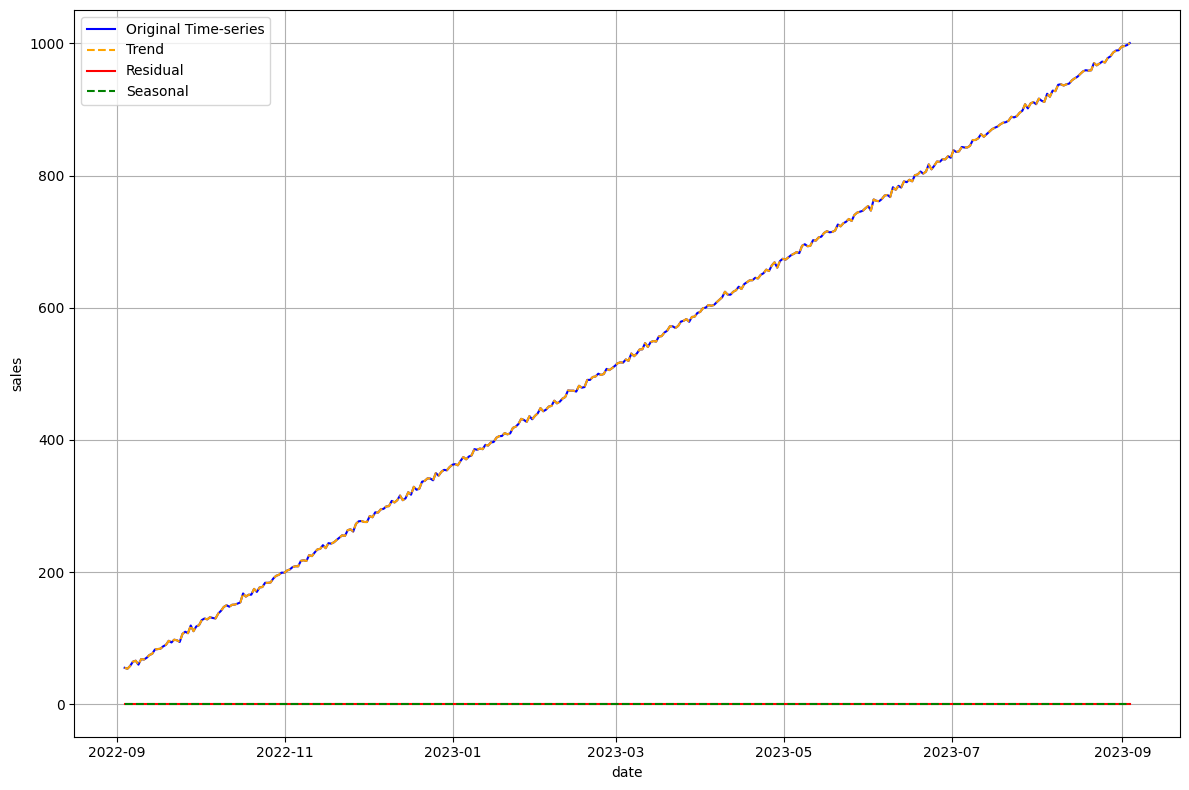

In [9]:
# -------------------------------
# STEP 3) DECOMPOSE TIME SERIES
# -------------------------------
print("STEP 3) DECOMPOSE TIME SERIES")

# Copy previous DataFrame and Series
df_timeseries_S3 = df_timeseries_S2.copy()
serie_date_time_S3 = serie_date_time_S2.copy()
df_S3_freq_ratio = df_S1_freq_ratio

# 1) Validate series regularity before decomposition
if df_S3_freq_ratio < freq_ratio_threshold:
    raise ValueError(f"Decomposition skipped due to Low frequency regularity (freq_ratio={df_S3_freq_ratio:.3f})")
log(f"Timestamp regularity OK (freq_ratio={df_S3_freq_ratio:.3f})", level=1, type="SUCCESS")

# 2) Detect period using ACF (primary robust method)
period_acf = infer_period_from_acf(df_timeseries_S3)
if period_acf is not None:
    period_S3 = period_acf
    log(f"Seasonality detected via ACF → period = {period_acf}", level=1, type="SUCCESS")
else:
    log("No significant seasonality found via ACF", level=1, type="WARNING")

    # 3) Fallback based on granularity (if ACF failed)
    period_fallback = infer_period_from_granularity(granularity)
    if period_fallback is None:
        raise ValueError("Unable to infer any valid period. Decomposition skipped because it is impossible to infer any valid period")
    log(f"Fallback period inferred: {period_fallback} (granularity={granularity})", level=1, type="SUCCESS")
    period_S3 = period_fallback

# 4) Determine model: additive or multiplicative
seasonal_component_type_S3 = infer_seasonal_component_type(df_timeseries_S3, seasonal_component_type_threshold)
log(f"Type of seasonal component selected: {seasonal_component_type_S3}", level=1, type="SUCCESS")

# 5) Perform decomposition
try:
    decomposition_S3 = seasonal_decompose(x=df_timeseries_S3, model=seasonal_component_type_S3, period=period_S3)
    trend_S3 = decomposition_S3.trend
    seasonal_S3 = decomposition_S3.seasonal
    residual_S3 = decomposition_S3.resid
    log("Decomposition completed successfully", level=1, type="SUCCESS")
except Exception as e:
    raise ValueError(f"Decomposition failed: {e}")

# 6) Compute seasonality strength metrics
strong_seasonality_S3, seasonality_metrics_S3 = assess_seasonality_strength(
    original        = df_timeseries_S3,
    seasonal        = seasonal_S3,
    period          = period_S3,
    acf_threshold   = strong_seasonal_threshold_for_acf,
    var_ratio       = strong_seasonal_threshold_for_var_ratio
)
if strong_seasonality_S3:
    log(f"Strong seasonality detected (var_ratio={seasonality_metrics_S3["seasonal_var_ratio"]:.3f}, acf={seasonality_metrics_S3["acf_at_period"]:.3f})", level = 1, type  = "SUCCESS")
else:
    log(f"Weak or no seasonality (var_ratio={seasonality_metrics_S3["seasonal_var_ratio"]:.3f}, acf={seasonality_metrics_S3["acf_at_period"]:.3f})", level = 1, type  = "WARNING")

# 7) Plot decomposition
fig, axis = plt.subplots(figsize = (figWidth_unit, figHeight_unit))
sns.lineplot(data = df_timeseries_S3, color = "blue", label = "Original Time-series")
sns.lineplot(data = trend_S3, color = "orange", label = "Trend", linestyle = "--")
sns.lineplot(data = residual_S3, color = "red", label = "Residual")
sns.lineplot(data = seasonal_S3, color = "green", label = "Seasonal", linestyle = "--")
plt.grid(True)
plt.tight_layout()
plt.show()

CONCLUSIONS:
- TREND: confirmed ascendent
- SEASONAL: 1 day period

In [16]:
accepted_alpha_dickey_fuller = 0.05 # Accepted error in the hypothesis

In [ ]:
# -------------------------------
# STEP 4) STACIONARY ANAYSIS
# -------------------------------
print("STEP 4) STACIONARY ANAYSIS")

# Copy previous DataFrame and Series
df_timeseries_S4 = df_timeseries_S3.copy()

# Perform Dickey-Fuller test to check for stacionarity
series_Dickey_Fuller_results = test_stationarity(series=df_timeseries_S4)

if series_Dickey_Fuller_results["p-value"] >= accepted_alpha_dickey_fuller:
    log(f"Dickey-Fuller test's results:\n{series_Dickey_Fuller_results}\n", level=1, type="INFO")
    log(f"Hyphotesis rejected:Time-series IS NOT stationary, recursive differenciation is carried out\n", level=1, type="WARNING", bold = True)
    # Peform recursively Dickley-Fuller test until the time-series becomes stacionary
    df_stationary_timeseries_S4, diff_count_S4, series_recursive_Dickey_Fuller_results = make_stationary_recursive(
        series=df_timeseries_S4,
        alpha=accepted_alpha_dickey_fuller
        )
    log(f"Recursive differenciation ({diff_count_S4} step/s) -> Dickey-Fuller test's results:\n{series_recursive_Dickey_Fuller_results}\n", level=1, type="INFO")

    if series_recursive_Dickey_Fuller_results["p-value"] >= accepted_alpha_dickey_fuller:
        log(f"Time-series cannot become stationary (after {diff_count_S4} differencing step/s)", level=1, type="WARNING", bold = True)
    else:
        log(f"Time-series can become stationary (after {diff_count_S4} differencing step/s)", level=1, type="SUCCESS", bold = True)
else:
    log(f"Hyphotesis accepted: time-series IS stationary, no need of differenciation", level=1, type="SUCCESS", bold = True)


STEP 4) STACIONARY ANAYSIS
• ℹ️ Dickey-Fuller test's results:
Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

• ⚠️ Hyphotesis rejected:Time-series IS NOT stationary, recursive differenciation is carried out

• ℹ️ Recursive differenciation (1 step/s) -> Dickey-Fuller test's results:
Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64

• ✅ Time-series can become stationary (after 1 differencing step/s)


In [ ]:
# -------------------------------
# STEP 5) VARIABILITY ANALYSIS
# -------------------------------
print("STEP 5) VARIABILITY ANALYSIS")

# Copy previous DataFrame and Series
residual_S5 = residual_S3.copy()
seasonal_component_type_S5 = seasonal_component_type_S3

# Drop NaN values in residuals
residual_S5 = residual_S5.dropna()
# -------------------------------------------
# RULE A: Check for visible trend in residuals
# -------------------------------------------
# Compute simple linear regression on residual vs time index
x_index = np.arange(len(residual_S5))
# Fit linear regression slope
slope, intercept = np.polyfit(x_index, residual_S5.values, 1)
# Compute residual standard deviation
residual_std = np.std(residual_S5)
# If residuals are almost constant → no trend by definition
if residual_std < 1e-8:
    log("Residual's slope analysis: Residuals are almost constant → no visible trend (good).", level=1, type="SUCCESS")
else:
    # Define a tolerance based on std and a minimum absolute tolerance
    if abs(slope) < max(residual_std * 0.01, 1e-6):
        log("Residual's slope analysis: No visible trend detected (good).", level=1, type="SUCCESS")
    else:
        log("Residual's slope analysis: Trend detected in residuals (bad).", level=1, type="WARNING", bold=True)

# -------------------------------------------
# RULE B: Check periodicity using ACF
# -------------------------------------------
# If residuals are almost constant → ACF cannot detect periodicity, assume GOOD
if residual_std < 1e-8:
    log("Residual's ACF analysis: Residuals are almost constant → no periodicity possible (good).", level=1, type="SUCCESS")
else:
    # Compute ACF up to 40 lags safely
    nlags = min(40, len(residual_S5) - 2)
    acf_res = acf(residual_S5, nlags=nlags, fft=True, missing="drop")
    # Detect highest non-zero lag correlation
    acf_res_no0 = acf_res[1:]
    max_acf_lag = np.argmax(np.abs(acf_res_no0)) + 1
    max_acf_value = acf_res[max_acf_lag]
    # Log ACF
    log(f"Residual ACF strongest lag={max_acf_lag}, value={max_acf_value:.3f}", level=1, type="INFO")
    # If ACF is NaN → cannot infer periodicity → assume GOOD
    if np.isnan(max_acf_value):
        log("Residual's ACF analysis: ACF cannot be computed reliably (likely constant residuals) → no periodicity detected (good).", level=1, type="SUCCESS")
    # Periodicity rule: if max ACF < 0.3 → no meaningful periodicity
    elif abs(max_acf_value) < 0.3:
        log("Residual's ACF analysis: No periodic patterns detected (good).", level=1, type="SUCCESS")
    else:
        log("Residual's ACF analysis: Residuals show periodic patterns (bad).", level=1, type="WARNING", bold=True)

# -------------------------------------------
# 4) RULE C: Check that residuals are centered
# -------------------------------------------
# Set theoretical center depending on decomposition model
residual_center = 1.0 if seasonal_component_type_S5 == "multiplicative" else 0.0
# Compute mean and standard deviation of cleaned residuals
mean_res = residual_S5.mean()
sd_res = residual_S5.std()
# Define relative and absolute tolerances
threshold_center = max(sd_res * 0.05, 1e-6)
# Center rule: mean close to the expected center (0 additive, 1 multiplicative)
if abs(mean_res - residual_center) < threshold_center:
    log(f"Residual's center analysis: Residuals centered around expected center ({residual_center}) (good).", level=1, type="SUCCESS")
else:
    log(f"Residual's center analysis: Residuals not centered around expected center ({residual_center}) (bad).", level=1, type="WARNING")

# -------------------------------------------
# 5) RULE D: Check for randomness using Ljung–Box test
# -------------------------------------------
# Center residuals for randomness tests
residual_S5_centered = residual_S5 - residual_center
# Compute standard deviation
sd_res_centered = residual_S5_centered.std()
# If residuals are almost constant → cannot test randomness, but constant noise = GOOD
if sd_res_centered < 1e-8:
    log("Residual's randomness analysis: Residuals are almost constant → randomness cannot be tested, assumed random (good).", level=1, type="SUCCESS")
else:
    # Define safe number of lags
    safe_lag = min(10, len(residual_S5_centered) - 2)
    # Compute Ljung–Box p-value
    ljung_box_p = acorr_ljungbox(residual_S5_centered, lags=[safe_lag], return_df=True)["lb_pvalue"].iloc[0]
    # Log p-value
    log(f"Ljung–Box p-value (lag {safe_lag}) = {ljung_box_p:.4f}", level=1, type="INFO")
    # Randomness rule: if p > 0.05 → residuals behave like white noise
    if ljung_box_p > 0.05:
        log("Residual's randomness analysis: Residuals behave as random noise (good).", level=1, type="SUCCESS")
    else:
        log("Residual's randomness analysis: Residuals show correlation → not white noise (bad).", level=1, type="WARNING")

STEP 5) VARIABILITY ANALYSIS
• ✅ Residual's slope analysis: Residuals are almost constant → no visible trend (good).
• ✅ Residual's ACF analysis: Residuals are almost constant → no periodicity possible (good).
• ✅ Residual's center analysis: Residuals centered around expected center (1.0) (good).
• ✅ Residual's randomness analysis: Residuals are almost constant → randomness cannot be tested, assumed random (good).


STEP 6) AUTOCORRELATION ANALYSIS


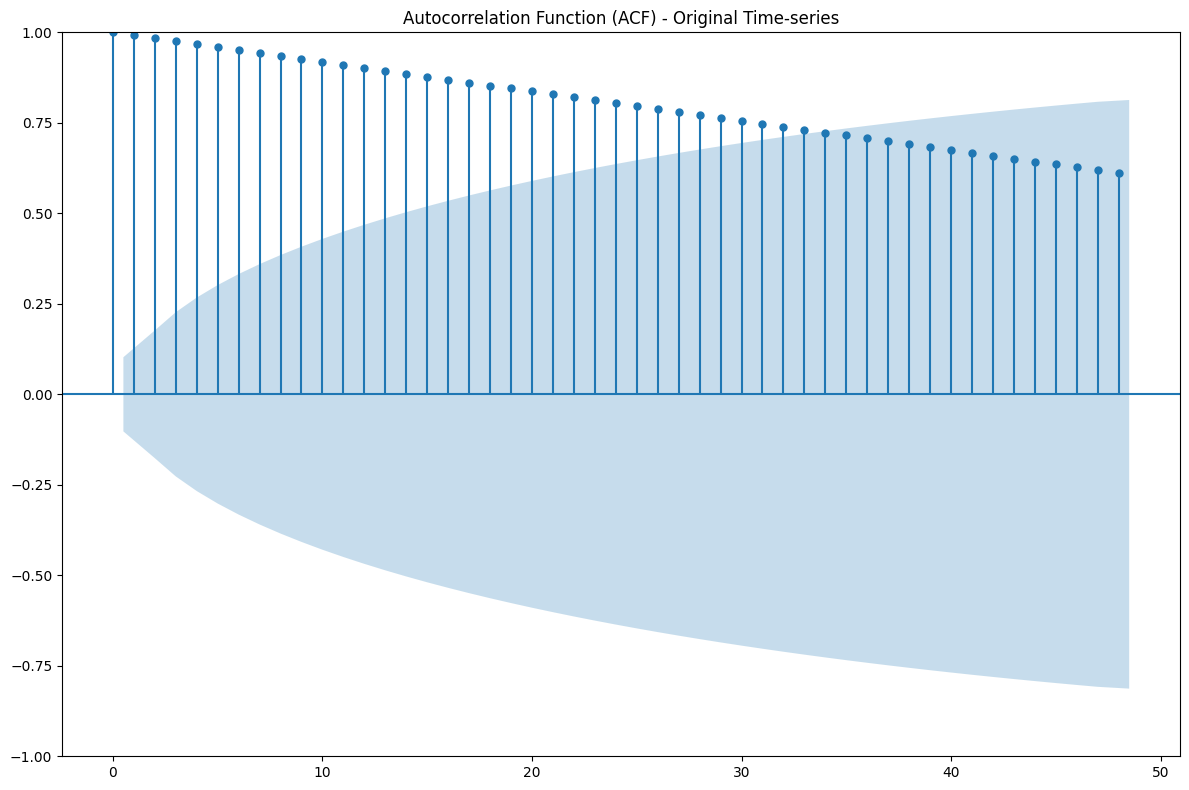

• ℹ️ ACF analysis: Significant autocorrelation at lags [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48].
• ℹ️ ACF analysis: High autocorrelation at short lags that decreases with lag → presence of trend and/or strong persistence.
• ✅ ACF analysis: Significant peaks at seasonal lags [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np

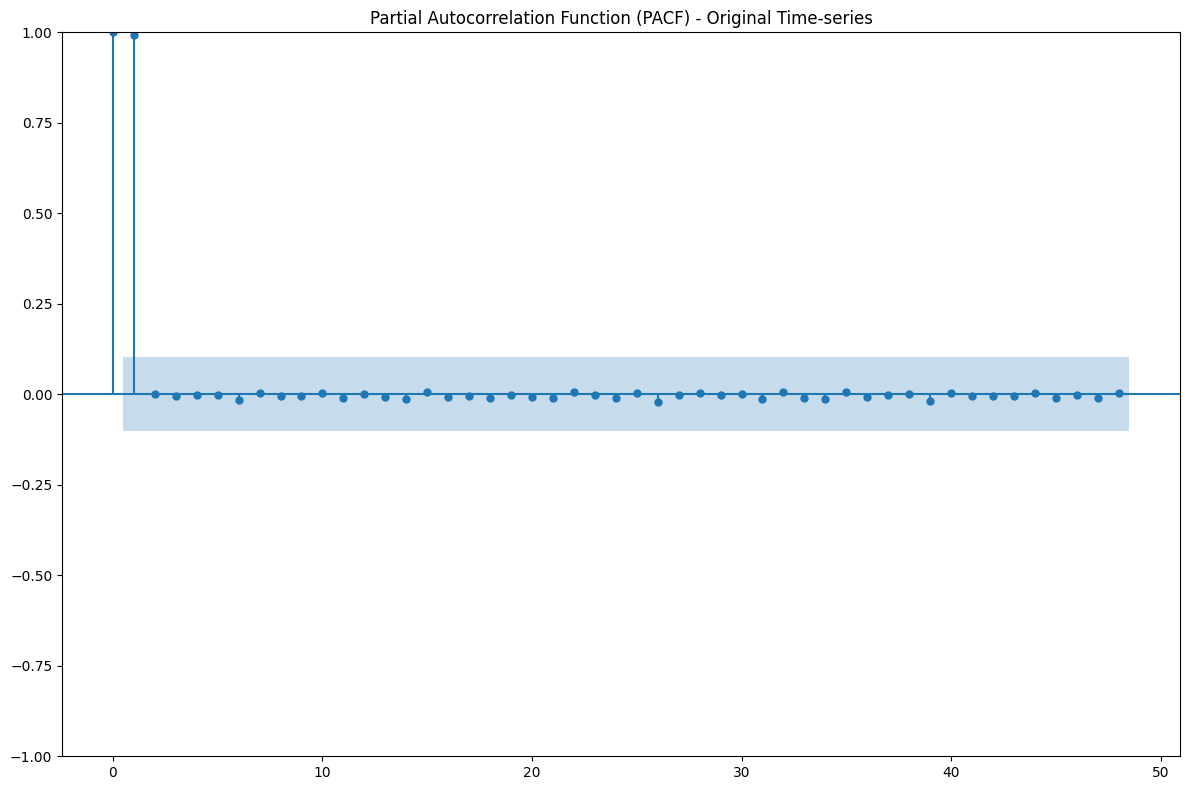

• ℹ️ PACF analysis: Significant partial autocorrelation at lags [1].
• ℹ️ Model suggestion based on ACF/PACF: AR(p) ≈ 0, MA(q) ≈ 1.


In [ ]:
# -------------------------------
# STEP 6) AUTOCORRELATION ANALYSIS (ACF & PACF)
# -------------------------------
print("STEP 6) AUTOCORRELATION ANALYSIS")

# Copy previous time-series
df_timeseries_S6 = df_timeseries_S3.copy()

# If series is almost constant → no meaningful ACF/PACF
if df_timeseries_S6.std() < 1e-8:
    log("ACF/PACF analysis: Time-series is almost constant → no meaningful autocorrelation.", level=1, type="WARNING")
else:
    # Define safe number of lags
    safe_lag = min(48, len(df_timeseries_S6) - 2)

    # -------------------------------------------
    # ACF: Autocorrelation Function
    # -------------------------------------------
    # Plot ACF of the original time-series
    fig, axis = plt.subplots(figsize=(figWidth_unit, figHeight_unit))
    plot_acf(df_timeseries_S6, lags=safe_lag, ax=axis)
    plt.title("Autocorrelation Function (ACF) - Original Time-series")
    plt.tight_layout()
    plt.show()

    # Compute numerical ACF values
    acf_vals = acf(df_timeseries_S6, nlags=safe_lag, fft=True, missing="drop")
    # Compute approximate confidence limit (95%)
    conf_limit = 1.96 / np.sqrt(len(df_timeseries_S6))
    # Detect significant ACF lags
    significant_acf_lags = [lag for lag, val in enumerate(acf_vals[1:], start=1) if abs(val) > conf_limit]

    # Log global ACF behaviour
    if len(significant_acf_lags) == 0:
        log("ACF analysis: No significant autocorrelation detected → series close to white noise.", level=1, type="INFO")
    else:
        log(f"ACF analysis: Significant autocorrelation at lags {significant_acf_lags}.", level=1, type="INFO")

        # Check short-lag behaviour (trend / persistence)
        short_lags = [lag for lag in significant_acf_lags if lag <= min(12, safe_lag)]
        if len(short_lags) > 0:
            log("ACF analysis: High autocorrelation at short lags that decreases with lag → presence of trend and/or strong persistence.", level=1, type="INFO")

        # Check seasonality based on period inferred in STEP 3
        if (period_S3 is not None) and (period_S3 <= safe_lag):
            # Build multiples of the detected period
            seasonal_multiples = [k * period_S3 for k in range(1, safe_lag // period_S3 + 1)]
            # Keep only those that are significant
            seasonal_peaks = [lag for lag in seasonal_multiples if lag in significant_acf_lags]
            if len(seasonal_peaks) > 0:
                log(f"ACF analysis: Significant peaks at seasonal lags {seasonal_peaks} (multiples of period={period_S3}) → strong seasonality.", level=1, type="SUCCESS")

    # -------------------------------------------
    # PACF: Partial Autocorrelation Function
    # -------------------------------------------
    # Plot PACF of the original time-series
    fig, axis = plt.subplots(figsize=(figWidth_unit, figHeight_unit))
    plot_pacf(df_timeseries_S6, lags=safe_lag, ax=axis, method="ywm")
    plt.title("Partial Autocorrelation Function (PACF) - Original Time-series")
    plt.tight_layout()
    plt.show()

    # Compute numerical PACF values
    pacf_vals = pacf(df_timeseries_S6, nlags=safe_lag, method="ywm")
    # Detect significant PACF lags
    significant_pacf_lags = [lag for lag, val in enumerate(pacf_vals[1:], start=1) if abs(val) > conf_limit]

    # Log PACF behaviour
    if len(significant_pacf_lags) == 0:
        log("PACF analysis: No significant partial autocorrelation detected.", level=1, type="INFO")
    else:
        log(f"PACF analysis: Significant partial autocorrelation at lags {significant_pacf_lags}.", level=1, type="INFO")

        # Suggest AR order ignoring purely seasonal multiples (if period_S3 available)
        if period_S3 is not None:
            non_seasonal_pacf = [lag for lag in significant_pacf_lags if lag % period_S3 != 0]
        else:
            non_seasonal_pacf = significant_pacf_lags

        if len(non_seasonal_pacf) > 0:
            suggested_p = non_seasonal_pacf[0]
            log(f"PACF analysis: First significant non-seasonal lag at {suggested_p} → candidate AR order p ≈ {suggested_p}.", level=1, type="INFO")

    # -------------------------------------------
    # MODEL ORDER SUGGESTION (AR / MA)
    # -------------------------------------------
    suggested_p = non_seasonal_pacf[0] if len(non_seasonal_pacf) > 0 else 0
    suggested_q = significant_acf_lags[0] if len(significant_acf_lags) > 0 else 0
    log(f"Model suggestion based on ACF/PACF: AR(p) ≈ {suggested_p}, MA(q) ≈ {suggested_q}.", level=1, type="INFO")

